In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

import gpplot as gpp
gpp.set_aesthetics()

Process of identifying 900 intergenic-targeting guides for Jacquere that resemble the Aggregate CFD and RS3 distribution of targeting guides in Jacquere. Doing so allows ensures that these are the right controls to use; that the spread of log fold changes represents the true noise expected of the targeting guides so that they more likely require a functionally relevant effect to emerge as significantly different from intergenics.  


Steps:
1. Acquire list of intergenics to choose from
2. Run intergenics through BLAT to obtain their coordinates
3. Obtain intergenic Aggregate CFD and RS3 scores by running their coordinates through CRISPick
4. Select a subset of 900 intergenics that mirrors the Aggregate CFD and RS3 distribution of targeting guides in Jacquere
   

### Acquiring list of intergenics to choose from

In [ ]:
#list of 10000 intergenic guide sequences (20bp) generated by GPP informatics team
intergenics_10000= pd.read_table("../Data/Negative Controls/sgrna-negcontrols-onesite-9606-GRCh38-SpyoCas9-10000.txt").reset_index().drop([0],axis=0)
intergenics_10000=intergenics_10000["level_0"].tolist()


### Run intergenics through BLAT to obtain their coordinates



How I downloaded blat/ made available to use:
1. downloaded the blat executable from [here](https://hgdownload.soe.ucsc.edu/admin/exe/macOSX.x86_64/blat/)
2. activated my virtual environment
3. moved the blat executable to the bin folder of the virtual environment that I am using
4. entered "chmod +x ~ /base_analysis/bin/blat" to gain permissions to use (~/base_analysis is the path to my virtual environment)
5. requested administrator access, then went to settings > Privacy & Security then scrolled to the notice that blat was blocked and indicated to download anyways

Running BLAT [user guide](https://genome.ucsc.edu/goldenPath/help/blatSpec.html)
1. download database fasta as instructed on [FAQ page](https://genome.ucsc.edu/FAQ/FAQblat.html#blat14) : hg38.2bit
2. export intergenic sequences to query for (below)
3. usage: blat hg38.2bit intergenic_10000_sequences.fa intergenics_blat_output.psl -noHead -minScore=20 -minMatch=1
   
   *if you get the error "operation timed out", just run it again...*
5. Process output (below) to retrieve the strand, chromosome, and position of the intergenic site to supply as coordinates for CRISPick to obtain RS3 score and aggregate CFD

In [ ]:
#export intergenic sequences as fasta for input to BLAT
with open('../Data/Negative Controls/intergenic_10000_sequences.fa', 'w') as f:
    lab=0
    for guide in intergenics_10000:
        f.write(f'>{lab}\n{guide}\n')
        lab=lab+1


In [ ]:
#reading in results from blat to get coordinates of intergenics
blat_output= pd.read_table("../Data/Negative Controls/intergenics_blat_output.psl",header=None)
blat_output["strand"]=blat_output[8]
blat_output["chromosome"]=blat_output[13]
#drop sequences that map to alternate or "random" chromosomes
blat_output=blat_output[blat_output["chromosome"].str.count("alt")==0].reset_index(drop=True)
blat_output=blat_output[blat_output["chromosome"].str.count("random")==0].reset_index(drop=True)

blat_output['start']=blat_output[15]
blat_output['end']=blat_output[16]
#context sequence begins 4 nucleotides before the 20bp guide and ends 6 nucleotides after
# indicate start or end of context sequence so that coordinates are always ascending (i.e. start becomes end if on reverse strand)
blat_output['context_start']=np.where(blat_output["strand"]=="+",blat_output["start"]-4,blat_output["start"]-6)
blat_output['context_end']=np.where(blat_output["strand"]=="+",blat_output["end"]+6,blat_output["end"]+4)

#getting coordinates in format as specified by CRISPick
blat_output["CRISPick input"]=blat_output.apply(lambda x: str(x["chromosome"])+":"+x["strand"]+":"+str(x["context_start"])+"-"+str(x["context_end"]), axis=1)

#export intergenic coordinates to supply to CRISPick for RS3 scores
with open('../Data/Negative Controls/intergenic_coordinates.fa', 'w') as f:
    for guide in blat_output["CRISPick input"]:
        f.write(f'{guide}\n')

### Obtain intergenic Aggregate CFD and RS3 scores by running their coordinates through CRISPick
Upload file above with a quota of 1 to CRISPick to obtain RS3 score and Aggregate CFD. Reading in results below

In [ ]:
crispick_intergenics=pd.read_table("../Data/Negative Controls/jacquere-intergenics-sgrna-designs.txt",usecols=["sgRNA Sequence","On-Target Efficacy Score","Aggregate CFD Score"])
#remove any intergenics with Aggregate CFD >4.8
crispick_intergenics=crispick_intergenics[crispick_intergenics["Aggregate CFD Score"]<=4.8].reset_index(drop=True)

print("All intergenics mean agg cfd:",round(crispick_intergenics["Aggregate CFD Score"].mean(),3))
print("All intergenics standard deviation agg cfd:",round(crispick_intergenics["Aggregate CFD Score"].std(),3))

print("\nAll intergenics mean RS3:",round(crispick_intergenics["On-Target Efficacy Score"].mean(),3))
print("All intergenics standard deviation RS3:",round(crispick_intergenics["On-Target Efficacy Score"].std(),3))

All intergenics mean agg cfd: 0.428
All intergenics standard deviation agg cfd: 0.692

All intergenics mean RS3: 0.891
All intergenics standard deviation RS3: 0.342


### Select subset of 900 intergenics mirroring the Aggregate CFD, RS3 distribution of targeting guides in Jacquere

In [ ]:
#Retrieving mean and s.d. of aggregate CFD and RS3 of targeting guides in jacquere to know what to match with intergenics
jacquere=pd.read_csv("../Data/jacquere_assembled_crispick.csv",low_memory=False)

print("jacquere mean agg cfd:", round(jacquere["Aggregate CFD Score"].mean(),3))
print("jacquere standard deviation agg cfd:", round(jacquere["Aggregate CFD Score"].std(),3))

print("\njacquere mean rs3:",round(jacquere["On-Target Efficacy Score"].mean(),3))
print("jacquere standard deviation rs3:", round(jacquere["On-Target Efficacy Score"].std(),3))


jacquere mean agg cfd: 0.781
jacquere standard deviation agg cfd: 0.996

jacquere mean rs3: 1.017
jacquere standard deviation rs3: 0.305


In [ ]:
#Subsample intergenics to match RS3 and Agg. CFD distribution of targeting guides in Jacquere

selecting_intergenics= crispick_intergenics.copy()
picked_intergenic_seq=[]
for i in range(900):
    #sample random targeting guide from Jacquere
    jacquere_sample_targeting_guide_index=random.randint(0,len(jacquere))
    #retrieve the aggregate CFD and RS3 of the random targeting guide
    sample_aggcfd=jacquere.loc[jacquere_sample_targeting_guide_index,"Aggregate CFD Score"]
    sample_RS3=jacquere.loc[jacquere_sample_targeting_guide_index,"On-Target Efficacy Score"]


    #identify an intergenic with the closest RS3 and aggregate CFD
    selecting_intergenics["distance_from_sample_aggcfd"]=abs(selecting_intergenics["Aggregate CFD Score"]-sample_aggcfd)
    selecting_intergenics["distance_from_sample_RS3"]=abs(selecting_intergenics["On-Target Efficacy Score"]-sample_RS3)
    selecting_intergenics=selecting_intergenics.sort_values(by=["distance_from_sample_aggcfd","distance_from_sample_RS3"]).reset_index(drop=True)
    #add this intergenic to the list of picked intergenics
    picked_intergenic_seq.append(selecting_intergenics.loc[0,"sgRNA Sequence"])
    #remove the selected guide so that it is not picked twice
    selecting_intergenics=selecting_intergenics.drop([0],axis=0)

intergenics_900=crispick_intergenics[crispick_intergenics["sgRNA Sequence"].isin(picked_intergenic_seq)].reset_index(drop=True)

In [ ]:
print("\n900 intergenics mean agg cfd:",round(intergenics_900["Aggregate CFD Score"].mean(),3))
print("900 intergenics standard deviation agg cfd:",round(intergenics_900["Aggregate CFD Score"].std(),3))

print("\n900 intergenics mean rs3:",round(intergenics_900["On-Target Efficacy Score"].mean(),3))
print("900 intergenics standard deviation rs3:",round(intergenics_900["On-Target Efficacy Score"].std(),3))


900 intergenics mean agg cfd: 0.752
900 intergenics standard deviation agg cfd: 0.952

900 intergenics mean rs3: 0.947
900 intergenics standard deviation rs3: 0.329


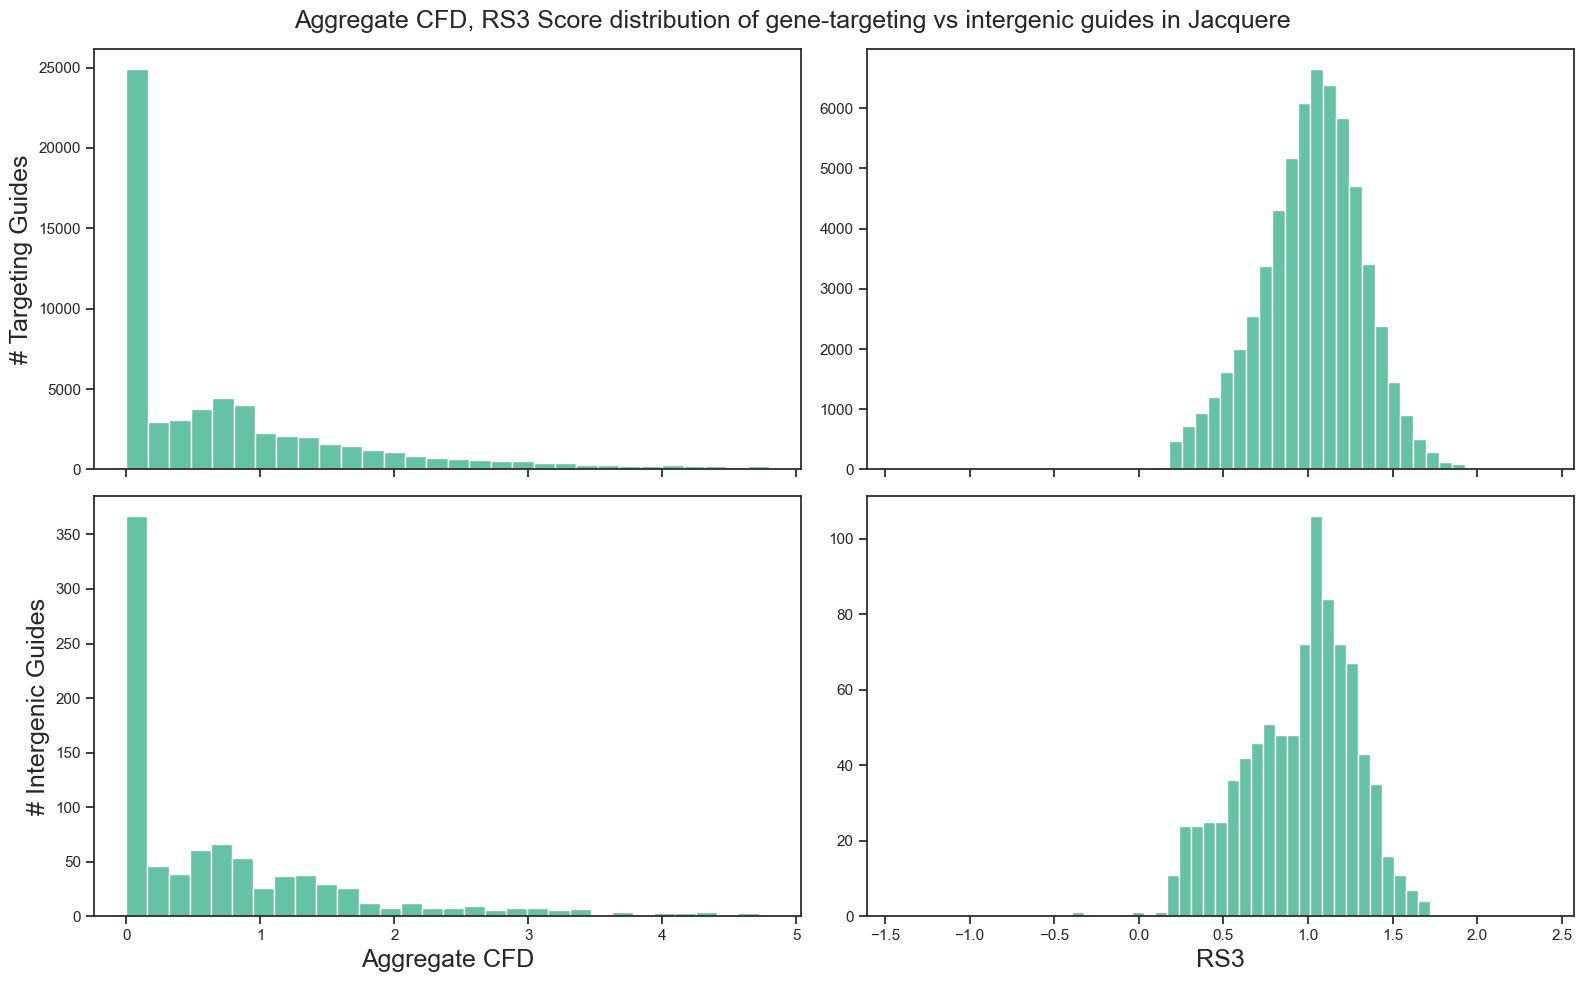

In [ ]:
(fig,ax)=plt.subplots(2,2,figsize=(16,10), sharex='col',layout="tight")
jacquere["Aggregate CFD Score"].hist(grid=False,bins=30,ax=ax[0,0])
jacquere["On-Target Efficacy Score"].hist(grid=False,bins=50,ax=ax[0,1])
intergenics_900["Aggregate CFD Score"].hist(grid=False,bins=30,ax=ax[1,0])
intergenics_900["On-Target Efficacy Score"].hist(grid=False,bins=30,ax=ax[1,1])

fig.suptitle("Aggregate CFD, RS3 Score distribution of gene-targeting vs intergenic guides in Jacquere",fontsize=18)
ax[0,0].set_ylabel("# Targeting Guides",fontsize=18)
ax[1,0].set_ylabel("# Intergenic Guides",fontsize=18)
ax[1,0].set_xlabel("Aggregate CFD",fontsize=18)
ax[1,1].set_xlabel("RS3",fontsize=18)
gpp.savefig("../Figures/RS3_aggcfd_distribution_intergenics_targeting.pdf",bbox_inches="tight",dpi=600)

In [ ]:
intergenics_900.to_csv("../Data/Negative Controls/jacquere_900_intergenics.csv",index=False)